# Richards model prediction of Covid-19 for Cuba: Updating plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

## Load data

In [2]:
# Global parameters
country = 'Cuba'
epidemic_start = 10 # minimum cumulative number of cases considered
ndays_limit = 31 # number of days since `epidemic_start` cases used to train the model
x_data_label = 'days_since_{}'.format(epidemic_start)

# loading data
df_input = pd.read_csv('data/cuba_data.csv', sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']

# Prepare data for model training
df = df_input[df_input['confirmed'] > epidemic_start][['date', 'confirmed', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.tail(10))

                 date  acumulado  new_cases  days_since_10
date                                                      
2020-04-14 2020-04-14        814         48             27
2020-04-15 2020-04-15        862         48             28
2020-04-16 2020-04-16        923         61             29
2020-04-17 2020-04-17        986         63             30
2020-04-18 2020-04-18       1035         49             31
2020-04-19 2020-04-19       1087         52             32
2020-04-20 2020-04-20       1137         50             33
2020-04-21 2020-04-21       1189         52             34
2020-04-22 2020-04-22       1235         46             35
2020-04-23 2020-04-23       1285         50             36


Note: This data can be more rencent than the data used to train the model. 

## Load previous fitted model

In [3]:
import pickle
with open('results/Cuba/model_data.pkl', 'rb') as buff:
    data = pickle.load(buff)  

richards_model, trace = data['model'], data['trace']

In [4]:
x_values = df[x_data_label].values[:ndays_limit]
y_values = df.acumulado.astype('float64').values[:ndays_limit]
dt_until = str(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')

# richards_model = pm.Model()

# with richards_model:
#     sigma = pm.HalfCauchy('sigma', 1, shape=1)
#     K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
#     rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
#     a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
#     x0 = pm.Uniform('x0', 1, 200, testval=15)
#     T = pm.Uniform('T', 1, 3, testval=1.2)
#     R0 = pm.Deterministic('R0', np.exp(rate * T))

#     # Create likelihood for data
#     x = pm.Data("x_data", x_values)
#     acumulado = pm.Data("y_data", y_values)
#     mu = K * (1 + np.exp(-rate * a * (x - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
#     y = pm.Normal('y', mu=mu, tau=sigma, observed=acumulado)

# ========== Compute predictions =============
h = 7  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:01<00:00, 55.88it/s]


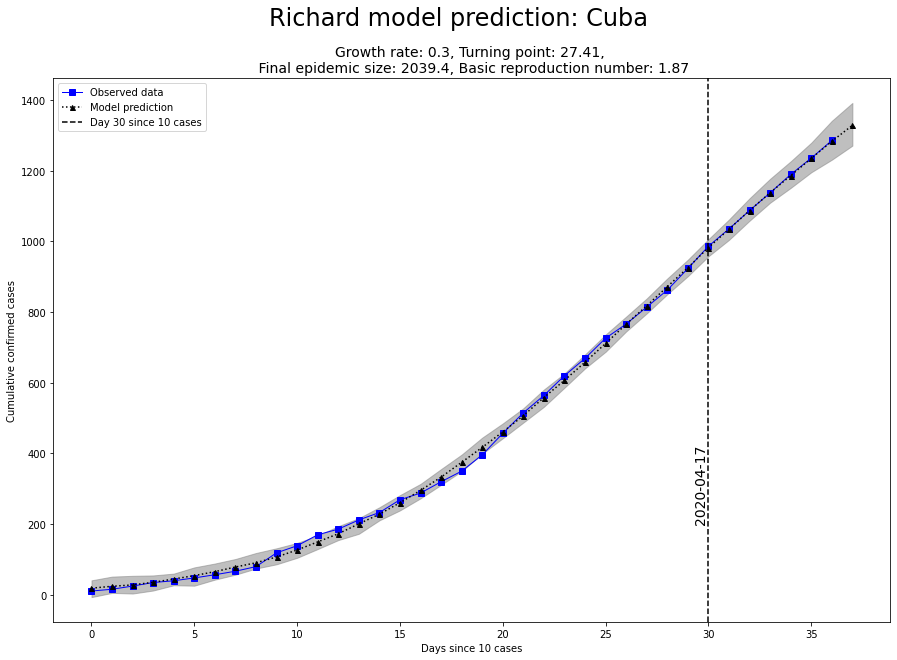

In [9]:
# Plot prediction of comulative cases
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label].values, df.acumulado.astype('float64').values,
         'b', marker='s', ls='-', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.5)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richard model prediction: {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

### Plot prediction of incidence of new cases

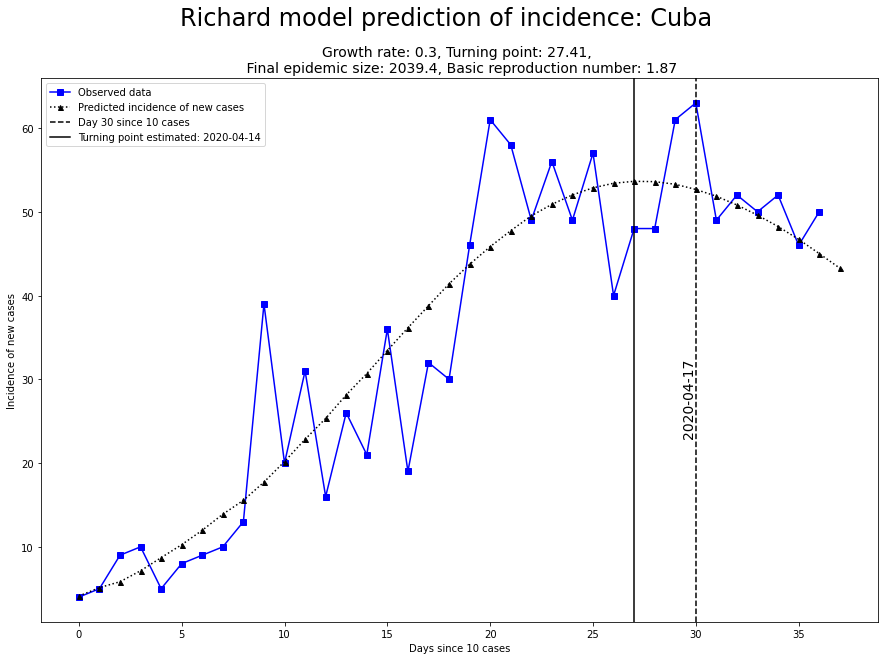

In [10]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richard model prediction of incidence: {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Input data with predictions

In [7]:
# Save data with predictions
df_pred = pd.DataFrame(index=pd.date_range(start=df.index[0], freq='D', periods=len(y_fit_final)))
df_pred[x_data_label] = np.arange(0, post_pred_final['y'].shape[1])
df_pred['acumulado_pred'] = y_fit_final
df_pred['acumulado_pred_lower'] = y_min_final
df_pred['acumulado_pred_upper'] = y_max_final
df_pred['new_cases_pred'] = dy_fit_final
df_full = pd.merge(df_pred, df, on=x_data_label, how='left')
df_full.index = df_pred.index
df_full['date'] = df_pred.index
cols_selected = ['date', x_data_label, 'acumulado', 'acumulado_pred',
                 'acumulado_pred_lower', 'acumulado_pred_upper', 'new_cases_pred']
df_full = pd.merge(df_input.drop('date', axis=1).reset_index(), 
                   df_full[cols_selected], on='date', how='outer')
df_full.index = df_full['date']
# df_full.to_csv('results/{}/{}_data_until_{}_predictions.csv'.format(country, country, dt_until),
#                index=False, sep=',', decimal='.')
df_full[['acumulado','acumulado_pred','new_cases','new_cases_pred']].tail(7).reset_index()

,date,acumulado,acumulado_pred,new_cases,new_cases_pred
0,2020-04-18,1035.0,1034.326556,49.0,51.858644
1,2020-04-19,1087.0,1086.954506,52.0,50.809665
2,2020-04-20,1137.0,1137.209098,50.0,49.599973
3,2020-04-21,1189.0,1185.815176,52.0,48.242947
4,2020-04-22,1235.0,1234.370625,46.0,46.709316
5,2020-04-23,1285.0,1282.645979,50.0,45.013229
6,2020-04-24,NaN,1327.841415,NaN,43.274741
